In [120]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio import Phylo
from collections import Counter
from scipy.optimize import curve_fit
import requests
import random

In [121]:
#Download tree json
tree_url = "https://data.nextstrain.org/ncov_global.json"

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

In [57]:
Phylo.write(tree, "global_tree.nexus", "nexus")

1

In [122]:
#Function to find path from root to clade
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path

Find non-nesting clades. Define the base as reaching at least 4 S1 mutations

In [123]:
threshold = 4

# initialize dictionary to store information for each clade 
# valeu will be node name of clade base and key will be
# the name of a representative isolate from the clade 
# (who's S1 mutational history will be considered))
clade_to_consider = {}

# keep track of the bases of clades that have already been visited (to avoid looking at nested subclades)
clade_bases = []


for node in tree.find_clades(terminal=False):

    # clade must have at least 10 tips
    if len(node.get_terminals())>=10:
        if "S1_mutations" in node.node_attrs:
            if node.node_attrs["S1_mutations"]["value"] >=threshold:
                clade_already_visited = False

                node_path = get_parent(tree, node)
                for parent in node_path:
                    if parent in clade_bases:
                        clade_already_visited = True

                if clade_already_visited == False:
#                     print(node.__dict__)
                    clade_bases.append(node)
                    

                    max_child_date = 0
                    representative_child = 'isolate_name'
                    for child in node.get_terminals():
                        child_date = child.node_attrs['num_date']['value']
                        if child_date > max_child_date:
                            max_child_date = child_date
                            representative_child = child.name
                            
                    clade_to_consider[representative_child] = node.name
                            
                    

Find the mutational path to the representative child in each clade

In [124]:
representatives = list(clade_to_consider.keys())

# initialize list to store dictionaries of mutational history 
# of the representative isolate from each clade
accumulation_s1_mutations = []

for node in tree.find_clades():
    
    if node.name in representatives:
        
        node_path = get_parent(tree, node)
        
        for parent in node_path:
            parent_date = parent.node_attrs['num_date']['value']


            if "S1_mutations" in parent.node_attrs:
                s1_mutations = parent.node_attrs["S1_mutations"]["value"]

                accumulation_s1_mutations.append({'date': parent_date, 
                                                  'num_s1_mutations': s1_mutations, 
                                                  'isolate': node.name, 
                                                  'clade_base': clade_to_consider[node.name]})
                

        
s1_mutation_history = pd.DataFrame(accumulation_s1_mutations)        

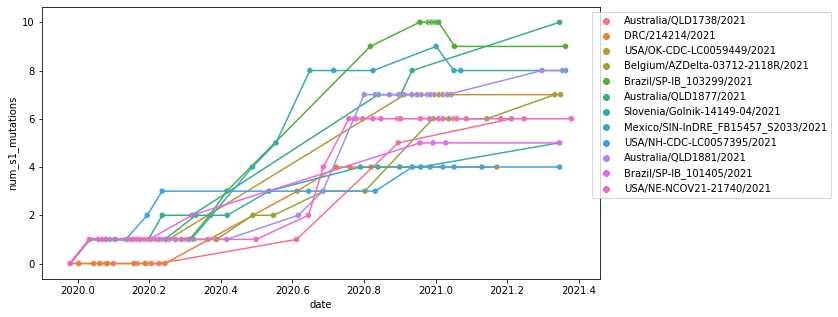

In [111]:


df_subset = s1_mutation_history[s1_mutation_history['isolate']=='USA/OK-CDC-LC0059449/2021']



fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=s1_mutation_history, x='date', y='num_s1_mutations', 
             hue='isolate',  ax=ax, legend=False)
sns.scatterplot(data=s1_mutation_history, x='date', y='num_s1_mutations', 
                hue='isolate',  ax=ax, legend=True)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.2, 1.0))


In [125]:
grouped = s1_mutation_history.groupby('isolate')

accumulation_periods = {}

for isolate_name, x in grouped:
        
    date_list = list(x['date'])
    s1_mut_list = list(x['num_s1_mutations'])

    start_s1_accumulation = next(x[0] for x in enumerate(s1_mut_list) if x[1] > 0)
    start_accumulation_date = date_list[start_s1_accumulation]
    
    # say that growth period has ended if the last 3 time points have same number of s1 muts
    if s1_mut_list[-3]==s1_mut_list[-1]:
        end_s1_accumulation = next(x[0] for x in enumerate(s1_mut_list) if x[1] == s1_mut_list[-1])
        end_accumulation_date = date_list[end_s1_accumulation]
        
    else:
        end_accumulation_date = None
    
    

    accumulation_periods[isolate_name] = {'start': start_accumulation_date, 
                                          'end': end_accumulation_date}

            

In [126]:
start_muts = []

for node in tree.find_clades(terminal=True):
    

    node_path = get_parent(tree, node)
    
    if node.name in accumulation_periods.keys():
        start_date = accumulation_periods[node.name]['start']
        end_date = accumulation_periods[node.name]['end']


        for parent in node_path:

            num_date = parent.node_attrs['num_date']['value']

            if (start_date - 0.3) < num_date < start_date:

                mutations_before_start = parent.branch_attrs['mutations']
                for gene, mut_list in mutations_before_start.items():
                    if gene!= 'nuc':
                        for mut in mut_list:
                            gene_mutation = f'{gene}_{mut}'
                            start_muts.append(gene_mutation)
                            
                            



In [127]:
end_muts = []

for node in tree.find_clades(terminal=True):

    node_path = get_parent(tree, node)
    
    if node.name in accumulation_periods.keys():
        end_date = accumulation_periods[node.name]['end']
        
        if end_date != None:

            for parent in node_path:

                num_date = parent.node_attrs['num_date']['value']

                if (end_date - 0.3) < num_date < (end_date + 0.1):

                    mutations_around_end = parent.branch_attrs['mutations']
                    for gene, mut_list in mutations_around_end.items():
                        if gene!= 'nuc':
                            for mut in mut_list:
                                gene_mutation = f'{gene}_{mut}'
                                end_muts.append(gene_mutation)



In [128]:
# lots of different changes, but most are to non-spike 
# see if, before all major clades that grow in S1 mutations, 
# if an ORF1a or 1b or N change happens just before S1 mutation accumulation

Counter(start_muts)

Counter()

In [129]:
Counter(end_muts)

Counter({'ORF1a_L3667F': 1,
         'ORF9b_R32P': 1,
         'S_V367F': 1,
         'S_Q613H': 1,
         'S_P681R': 1,
         'S_F157L': 1,
         'ORF1a_M3752I': 1,
         'N_P199L': 1,
         'ORF1b_Q1011H': 1,
         'S_L5F': 1,
         'S_T95I': 2,
         'S_D253G': 1,
         'S_A701V': 1,
         'S_E484K': 2,
         'ORF1a_S2981F': 1,
         'ORF3a_A33S': 1,
         'E_L21F': 1,
         'N_S2M': 1,
         'N_D3Y': 1,
         'N_A12G': 1,
         'ORF1a_T2007I': 1,
         'ORF1b_L314F': 1,
         'ORF6_F2-': 1,
         'ORF9b_H9D': 1,
         'S_Q52R': 1,
         'S_A67V': 1,
         'S_H69-': 2,
         'S_V70-': 2,
         'S_Y144-': 3,
         'S_Q677H': 1,
         'S_F888L': 1,
         'ORF1b_D1183Y': 1,
         'S_S13I': 1,
         'S_W152C': 1,
         'S_L452R': 1,
         'ORF1a_I4205V': 1,
         'S_P26S': 2,
         'N_G30R': 1,
         'ORF9b_M26I': 1,
         'ORF7b_W29L': 1,
         'S_R214L': 1,
         'M_I82T': 